In [12]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, REPORTS_DIR
from src.dataset import DatasetIO, DataModel
from src.feature_io import save_features

base_dataset = DatasetIO.load_dataset_pickle(INTERIM_DATA_DIR / "dataset_metadata_v3.pkl")

print(f"Base dataset: {base_dataset[0]}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2025-08-27 12:50:00.973 | INFO     | src.dataset:load_dataset_pickle:221 - Загрузка датасета из D:\workspace\projects\freelance\3d_recognition_analisis\data\interim\dataset_metadata_v3.pkl
2025-08-27 12:50:00.975 | SUCCESS  | src.dataset:load_dataset_pickle:224 - Датасет загружен: D:\workspace\projects\freelance\3d_recognition_analisis\data\interim\dataset_metadata_v3.pkl
Base dataset: DataModel(model_id='42. Ejector-01.prt', class_name='42. Ejector', model_path='D:\\workspace\\projects\\freelance\\3d_recognition_analisis\\data\\raw\\OLD3D\\42. Ejector\\42. Ejector-01.prt.stp', image_paths=[ImageData(image_id='42. Ejector-01.prt_ModelType.BACK', image_path='D:\\workspace\\projects\\freelance\\3d_recognition_analisis\\data\\raw\\2D\\v3\\42. Ejector\\42. Ejector-01.prt\\ModelType.BACK.png', class_name='42. Ejector'), ImageData(image_id='42. Ejector-01.prt_ModelType.BOTTOM', image_path='D:\\workspace\\

In [37]:
import os
from src.modeling.CNN1D.brep import BrepExtractor
import numpy as np
from tqdm import tqdm
from src.config import RAW_DATA_DIR

base = INTERIM_DATA_DIR / 'v3'

extractor = BrepExtractor()

all_features = []
all_labels = []



def walkdir(folder):
    """Walk through each files in a directory"""
    for dirpath, dirs, files in os.walk(folder):
        for filename in files:
            yield os.path.abspath(os.path.join(dirpath, filename))

for model_data in tqdm(base_dataset):
    features = extractor.extract(model_data.model_path)
    all_features.append(features)
    all_labels.append(model_data.class_name)

X = np.stack(all_features)
y = np.array(all_labels)

save_features(X, y, base / f"features_brep_matrix.npz")



2025-08-27 13:31:34.425 | INFO     | src.modeling.CNN1D.brep:__init__:57 - Инициализация (K=256, LBO=16, bins=64, D=256, mode=matrix)


100%|██████████| 129/129 [00:28<00:00,  4.51it/s]


Features shape: (129, 7, 256), Labels shape: (129,)


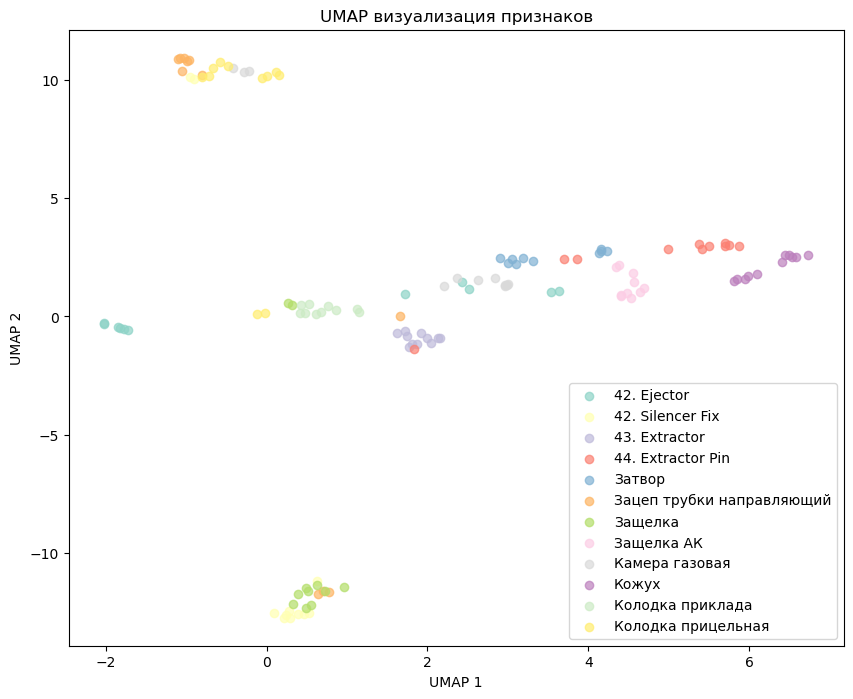

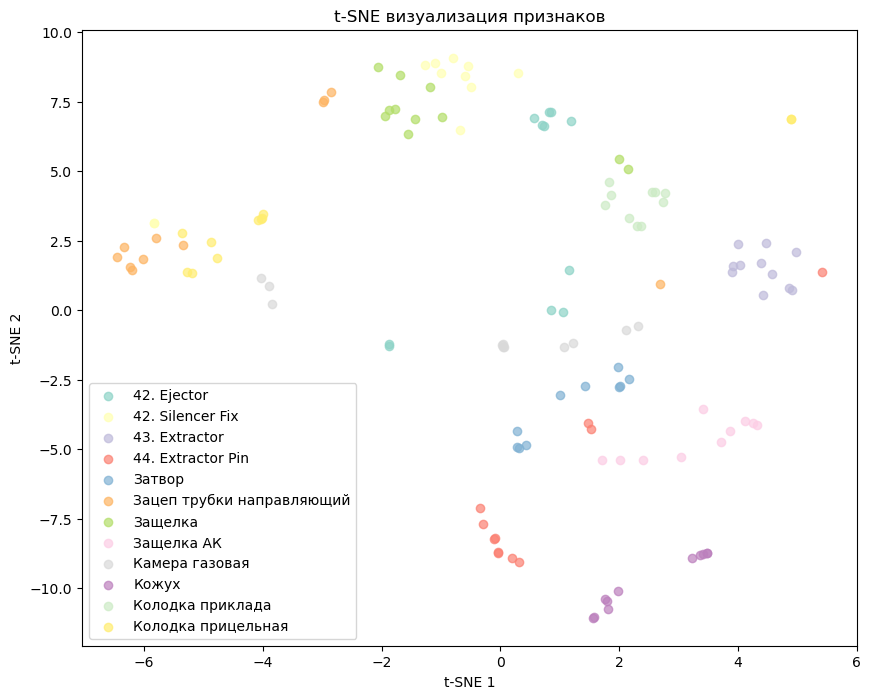

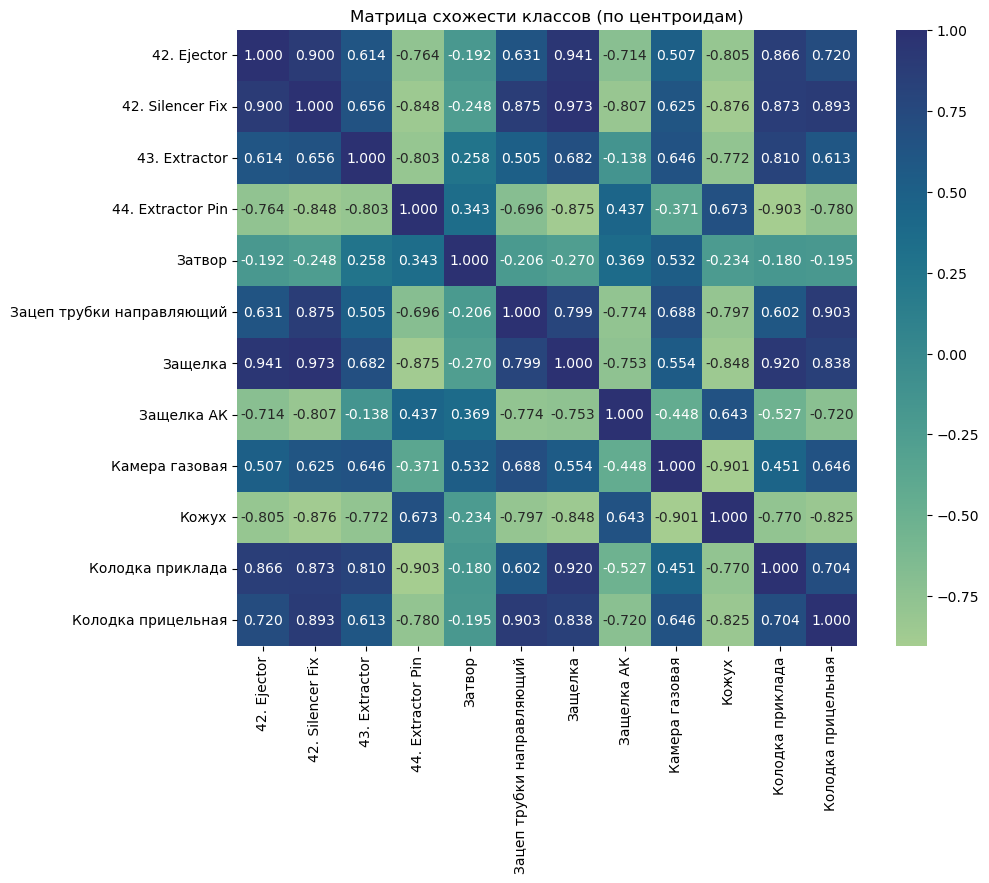

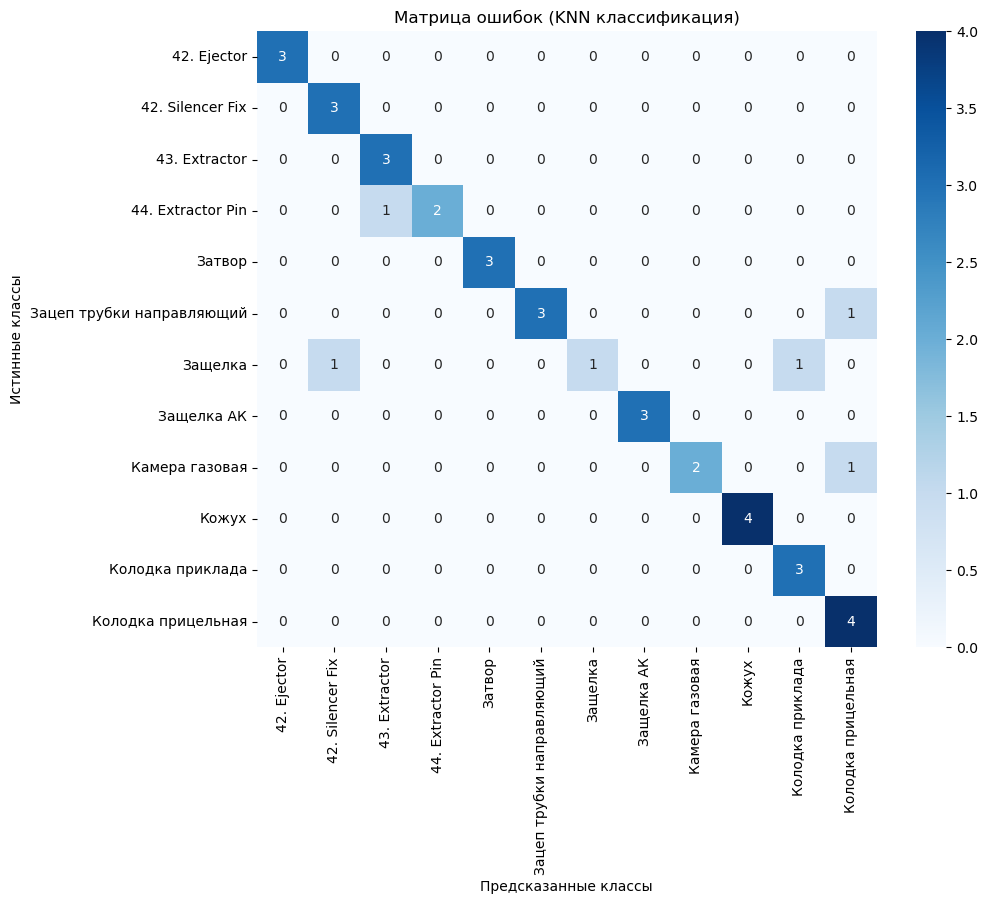

In [39]:

from src.plots import plot_clustering_umap, plot_clustering_tsne, plot_similarity_heatmap, plot_matrix_error
from src.feature_io import load_features
from sklearn.preprocessing import StandardScaler

X, y = load_features(base / "features_brep_matrix.npz") 

print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

X_pooled = X.mean(axis=1)
X_pooled = StandardScaler().fit_transform(X_pooled)
plot_clustering_umap(X_pooled, y, None)
plot_clustering_tsne(X_pooled, y, None)
plot_similarity_heatmap(X_pooled, y, None)
plot_matrix_error(X_pooled, y, None)

Training: 100%|██████████| 100/100 [00:30<00:00,  3.25it/s, loss=0.0175]


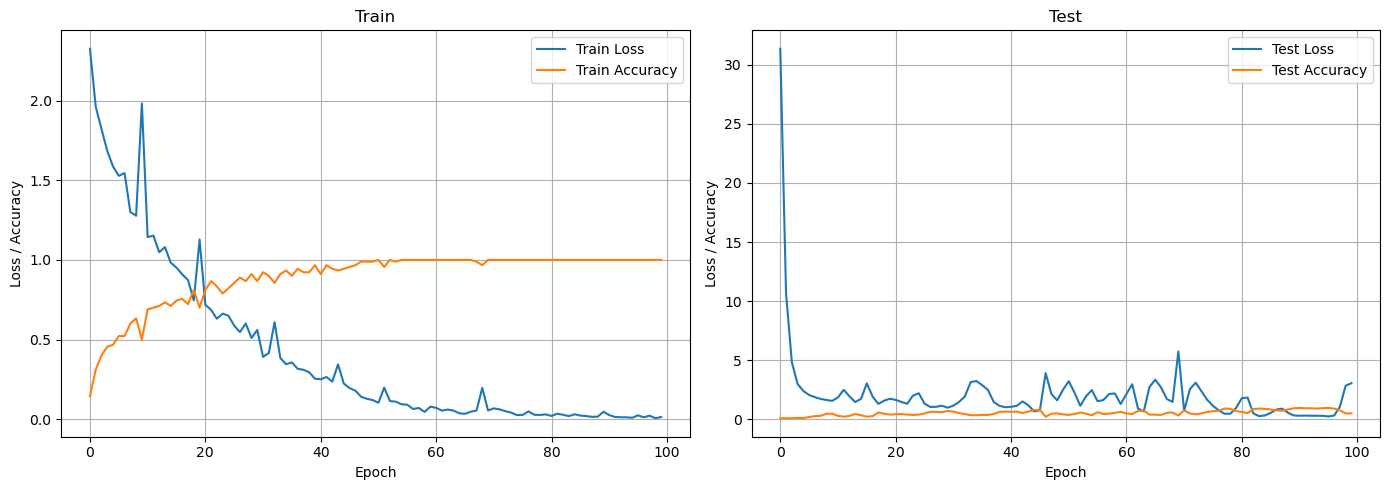

In [61]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from src.modeling.utils.augment import augment_batch_matrix, SpecAugConfig
from src.modeling.CNN1D.cnn1d import CNN1D
from src.modeling.CNN1D.mlp_pooled import PooledMLP
from tqdm import tqdm
import matplotlib.pyplot as plt


epochs = 100
# X: (num_samples, 7, 256), y: (num_samples,)
num_classes = len(np.unique(y))
model = CNN1D(num_classes=num_classes)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)



X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

specaug_cfg = SpecAugConfig(specaug_frac=0.10, specaug_slices=2, channel_drop_p=0.05)


# Оптимизатор и loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def info_nce_loss(emb, temperature=0.5):
    # emb: (batch, emb_dim)
    emb = F.normalize(emb, dim=1)
    similarity_matrix = emb @ emb.T  # (batch, batch)
    labels = torch.arange(emb.size(0)).to(emb.device)
    logits = similarity_matrix / temperature
    loss = F.cross_entropy(logits, labels)
    return loss

# Обучение
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

pbar = tqdm(range(epochs), desc="Training")
for epoch in pbar:
    epoch_loss = 0
    correct = 0
    total = 0
    batches = 0
    model.train()
    for xb, yb in train_loader:
        # x = augment_batch_matrix(xb.clone(), specaug_cfg)
        logits = model(xb)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
        loss = criterion(logits, yb)  # используйте классификационный loss для метрик
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        batches += 1
        pbar.set_postfix(loss=loss.item())
    train_loss_history.append(epoch_loss / batches)
    train_acc_history.append(correct / total)

    # Тест
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    test_batches = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            logits = model(xb)
            pred = logits.argmax(dim=1)
            test_correct += (pred == yb).sum().item()
            test_total += yb.size(0)
            loss = criterion(logits, yb)
            test_loss += loss.item()
            test_batches += 1
    test_loss_history.append(test_loss / test_batches)
    test_acc_history.append(test_correct / test_total)

# Визуализация
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(train_acc_history, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Train')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(test_loss_history, label='Test Loss')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Test')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

        map  silhouette  intra_class_distance  inter_class_distance  \
0  0.972865    0.430153              6.689156             20.184395   

   separation_ratio  samples  classes  feature_dim  
0           3.01748      129       12          256  


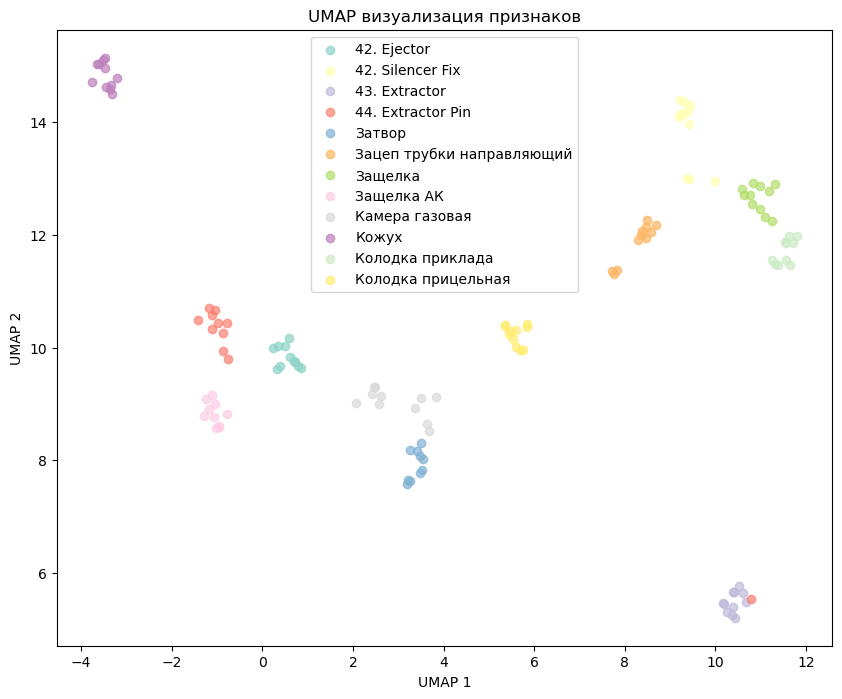

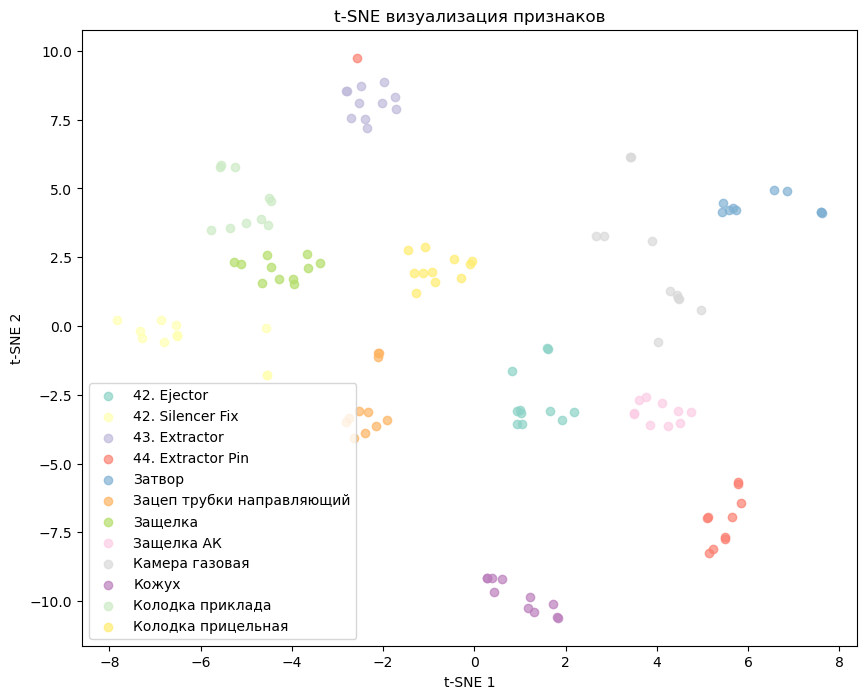

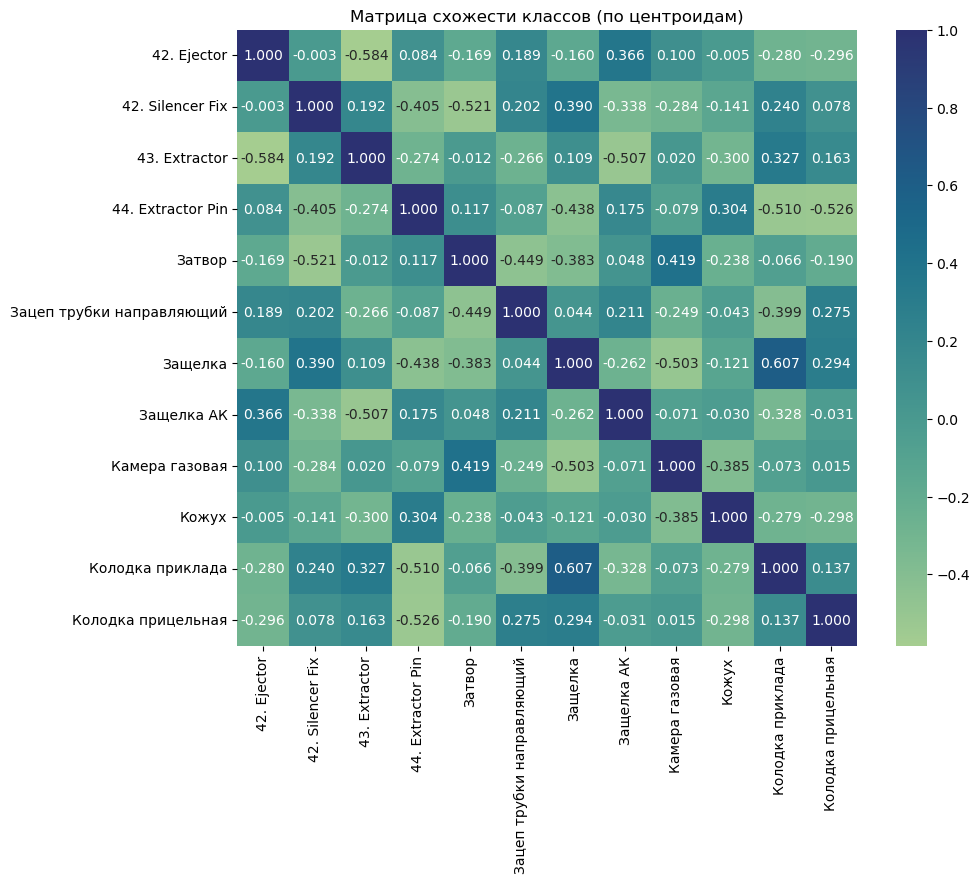

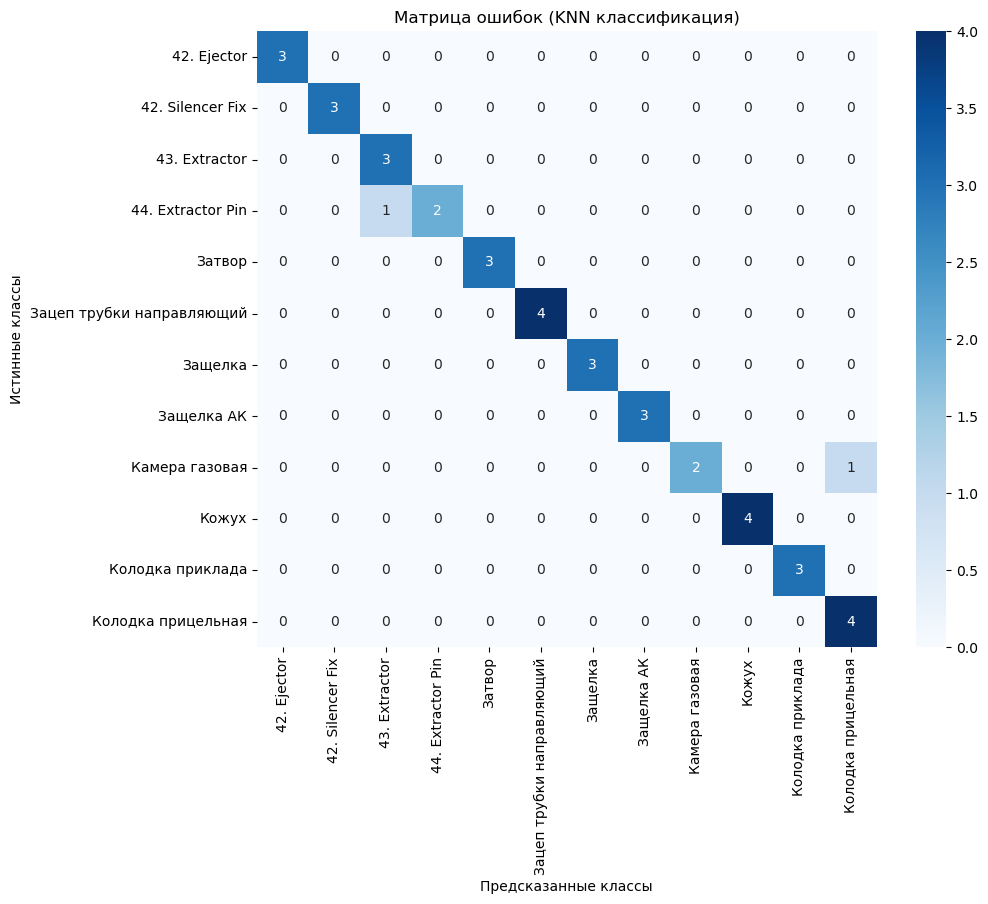

In [62]:
from src.metrics import get_metrics
import pandas as pd

model.eval()
features_nn = []
with torch.no_grad():
    for xb in DataLoader(torch.tensor(X, dtype=torch.float32), batch_size=32):
        emb = model(xb, return_embedding=True)  # (batch, emb_dim)
        features_nn.append(emb.cpu().numpy())
features_nn = np.concatenate(features_nn, axis=0)
features_nn = StandardScaler().fit_transform(features_nn)

save_features(features_nn, y, base / f"features_brep_cnn1d.npz")

metrics = get_metrics(features_nn, y)

metrics_df = pd.DataFrame([metrics])

print(metrics_df)

plot_clustering_umap(features_nn, y, None)
plot_clustering_tsne(features_nn, y, None)
plot_similarity_heatmap(features_nn, y, None)
plot_matrix_error(features_nn, y, None)